### Esercitazione 9 - ADX (Average Directional Index)
#### Argomenti

* indicatore ADX
* generazione automatica di segnali di buy/sell con ADX

L'indicatore di trend ADX (Average Directional Index) è usato per misurare la forza di un trend.
E' spesso utilizzato insieme ad altri due indicatori, -DI e +DI (Smoothed Minus Directional Indicator e Smoothed Plus
Directional Indicator) perché questi ultimi due forniscono una direzione, utile ad essere combinata con la forza
rilevata dall'ADX nello studiare un trend e sono necessari per il calcolo dell'ADX stesso.
Dalla letteratura, un valore di ADX superiore a 25 indica un trend forte, un valore sotto 20 indica un
trend debole; i valori intermedi tra 20 e 25 non offrono particolari indicazioni.
*(le formule per il calcolo sono descritte nel codice successivamente)*

In [1]:
from Historic_Crypto import  HistoricalData
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=180)
candles = HistoricalData(
    ticker='BTC-USD',
    granularity=3600,
    start_date=start_date.strftime('%Y-%m-%d-%H-%M'),
    end_date=end_date.strftime('%Y-%m-%d-%H-%M'),
    verbose=False
).retrieve_data()

Provisional Start: 2022-04-22T11:11:00
Provisional End: 2022-05-04T23:11:00
Provisional Start: 2022-05-04T23:11:00
Provisional End: 2022-05-17T11:11:00
Provisional Start: 2022-05-17T11:11:00
Provisional End: 2022-05-29T23:11:00
Provisional Start: 2022-05-29T23:11:00
Provisional End: 2022-06-11T11:11:00
Provisional Start: 2022-06-11T11:11:00
Provisional End: 2022-06-23T23:11:00
Provisional Start: 2022-06-23T23:11:00
Provisional End: 2022-07-06T11:11:00
Provisional Start: 2022-07-06T11:11:00
Provisional End: 2022-07-18T23:11:00
Provisional Start: 2022-07-18T23:11:00
Provisional End: 2022-07-31T11:11:00
Provisional Start: 2022-07-31T11:11:00
Provisional End: 2022-08-12T23:11:00
Provisional Start: 2022-08-12T23:11:00
Provisional End: 2022-08-25T11:11:00
Provisional Start: 2022-08-25T11:11:00
Provisional End: 2022-09-06T23:11:00
Provisional Start: 2022-09-06T23:11:00
Provisional End: 2022-09-19T11:11:00
Provisional Start: 2022-09-19T11:11:00
Provisional End: 2022-10-01T23:11:00
Provisional 

In [3]:
candles.head()

,low,high,open,close,volume
time,,,,,
2022-04-22 12:00:00,40360.25,40630.74,40592.86,40408.06,475.672727
2022-04-22 13:00:00,40034.19,40638.38,40408.23,40244.94,1642.229795
2022-04-22 14:00:00,39809.29,40448.99,40243.59,39864.83,1560.971633
2022-04-22 15:00:00,39319.00,40019.80,39863.92,39427.36,2234.779877
2022-04-22 16:00:00,39174.80,39530.00,39427.29,39380.49,1316.938566


In [4]:
# calcolo dell'ADX

def ADX(df, interval=14):
    # calcolo dell'indicatore +DM si effettua calcolando high attuale meno high precedente e
    # considerando solo i valori positivi, in modo da evidenziare salite di prezzo
    # in maniera analoga si ragiona per -DM su low, evidenziando le discese di prezzo
    df['+DM'] = df['high'] - df['high'].shift(1)
    df['-DM'] = df['low'].shift(1) - df['low']

    df['+DM'] = np.where((df['+DM'] > df['-DM']) & (df['+DM'] > 0), df['+DM'], 0.0)
    df['-DM'] = np.where((df['-DM'] > df['+DM']) & (df['-DM'] > 0), df['-DM'], 0.0)

    # calcolo del "true range", ovvero del delta maggiore tra quello calcolato su high
    # e low attuali, quello calcolato su high attuale e close precedente presi in valore
    # assoluto e quello calcolato su low attuale e close precedente presi in valore assoluto,
    # come per evidenziare la quantità di incremento o decremento di prezzo avuto
    # nell'ultima candela
    df['TR_TMP1'] = df['high'] - df['low']
    df['TR_TMP2'] = np.abs(df['high'] - df['close'].shift(1))
    df['TR_TMP3'] = np.abs(df['low'] - df['close'].shift(1))

    df['TR'] = df[['TR_TMP1', 'TR_TMP2', 'TR_TMP3']].max(axis=1)

    # filtraggio dei dati ottenuti, per attenuare piccoli sbalzi di prezzo,
    # applicando una media mobile sugli stessi
    # in questo modo, i valori di Directional Movement diventano un
    # indicatore e prendono il nome da +DM a +DMI e da -DM a -DMI
    df['TR' + str(interval)] = df['TR'].rolling(interval).sum()
    df['+DMI' + str(interval)] = df['+DM'].rolling(interval).sum()
    df['-DMI' + str(interval)] = df['-DM'].rolling(interval).sum()

    # calcolo degli indicatori di direzione positiva e negativa, rapportando
    # +DMI e -DMI all'intervallo "true-range" precedentemente calcolato
    df['+DI' + str(interval)] = df['+DMI' + str(interval)] / df['TR' + str(interval)] * 100
    df['-DI' + str(interval)] = df['-DMI' + str(interval)] / df['TR' + str(interval)] * 100

    # dopo aver quantificato la forza del trend positivo e negativo con +DI e -DI
    # possiamo sfruttare la distanza tra questi per classificare il trend attuale come
    # debole (distanza bassa) o forte (distanza alta)

    # calcolo del valore assoluto della differenza tra gli indicatori di direzione +DI e -DI
    df['DI' + str(interval) + '-'] = abs(df['+DI' + str(interval)] - df['-DI' + str(interval)])

    # somma tra gli indicatori di direzione +DI e -DI
    df['DI' + str(interval)] = df['+DI' + str(interval)] + df['-DI' + str(interval)]

    # indicatore di direzione (DX - Directional Index)
    # mette in rapporto la differenza tra l'indicatore direzionale positivo e negativo
    # con la somma dei due stessi indicatori
    df['DX'] = (df['DI' + str(interval) + '-'] / df['DI' + str(interval)]) * 100

    # calcolo dell'ADX tramite media mobile di DX
    df['ADX' + str(interval)] = df['DX'].rolling(interval).mean()

    # sostituzione dei valori NaN derivanti dal calcolo dei DM e del TR con
    # il valore medio dell'ADX
    #df['ADX' + str(interval)] = df['ADX' + str(interval)].fillna(df['ADX' + str(interval)].mean())

    # cancellazione delle colonne "temporanee" create per effettuare i
    # calcoli necessari
    del df['TR_TMP1'], df['TR_TMP2'], df['TR_TMP3'], df['TR'], df['TR' + str(interval)]
    del df['+DMI' + str(interval)], df['DI' + str(interval) + '-']
    del df['DI' + str(interval)], df['-DMI' + str(interval)]
    del df['DX']
    
    # rimozione valori NaN
    df = df[interval * 2:]
    return df

In [5]:
interval = 14

candles = ADX(candles, interval=interval)

candles.head()

,low,high,open,close,volume,+DM,-DM,+DI14,-DI14,ADX14
time,,,,,,,,,,
2022-04-23 16:00:00,39731.12,39993.82,39814.12,39868.65,397.720865,123.42,0.00,21.584158,7.564133,21.605643
2022-04-23 17:00:00,39722.56,39868.65,39868.65,39832.62,328.923969,0.00,8.56,21.532460,7.060477,21.676252
2022-04-23 18:00:00,39666.05,39868.08,39832.61,39692.87,290.657968,0.00,56.51,22.250370,4.434381,23.150315
2022-04-23 19:00:00,39676.93,39792.03,39692.86,39771.32,239.870642,0.00,0.00,19.552058,4.447942,26.697883
2022-04-23 20:00:00,39763.34,39843.06,39770.13,39815.24,283.794323,51.03,0.00,20.070050,4.545914,30.836123


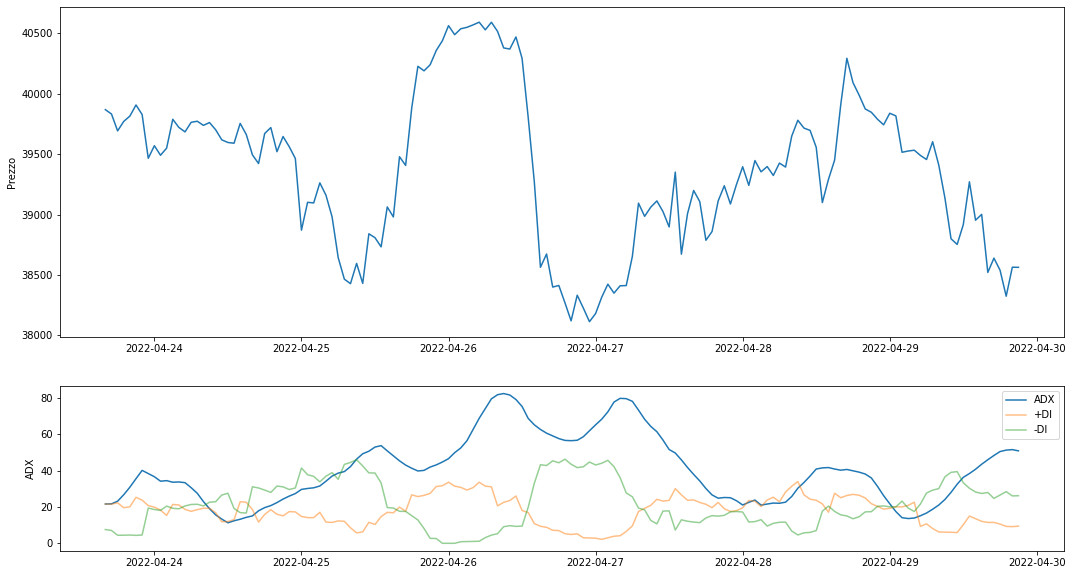

In [6]:
fig, (ax_price, ax_adx) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles[:150]['close'])
ax_price.set_ylabel('Prezzo')

ax_adx.plot(candles[:150]['ADX' + str(interval)], label='ADX')
ax_adx.plot(candles[:150]['+DI' + str(interval)], label='+DI', alpha=0.5)
ax_adx.plot(candles[:150]['-DI' + str(interval)], label='-DI', alpha=0.5)
ax_adx.set_ylabel('ADX')
ax_adx.legend()

plt.show()

In [7]:
# implementazione di una strategia che sfrutti ADX e indicatori di direzione
# positiva / negativa per impostare i punti in cui entrare long e short

# quando l'ADX passa da sotto il valore 25 a sopra il valore 25, verifichiamo
# il valore degli indicatori di direzione positiva / negativa per entrare,
# rispettivamente, in buy o in sell

def strategy(prices, adx, pdi, ndi):
    buy_price = []
    sell_price = []
    adx_action = []
    action = 0

    for i in range(1, len(prices)):
        if adx[i - 1] <= 25 <= adx[i] and pdi[i] > 30:
            if action != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                action = 1
                adx_action.append(action)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_action.append(0)
        elif adx[i - 1] <= 25 <= adx[i] and ndi[i] > 30:
            if action != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                action = -1
                adx_action.append(action)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_action.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            adx_action.append(0)

    return buy_price, sell_price, adx_action


buy_price, sell_price, adx_signal = strategy(
    candles['close'],
    candles['ADX' + str(interval)],
    candles['+DI' + str(interval)],
    candles['-DI' + str(interval)]
)

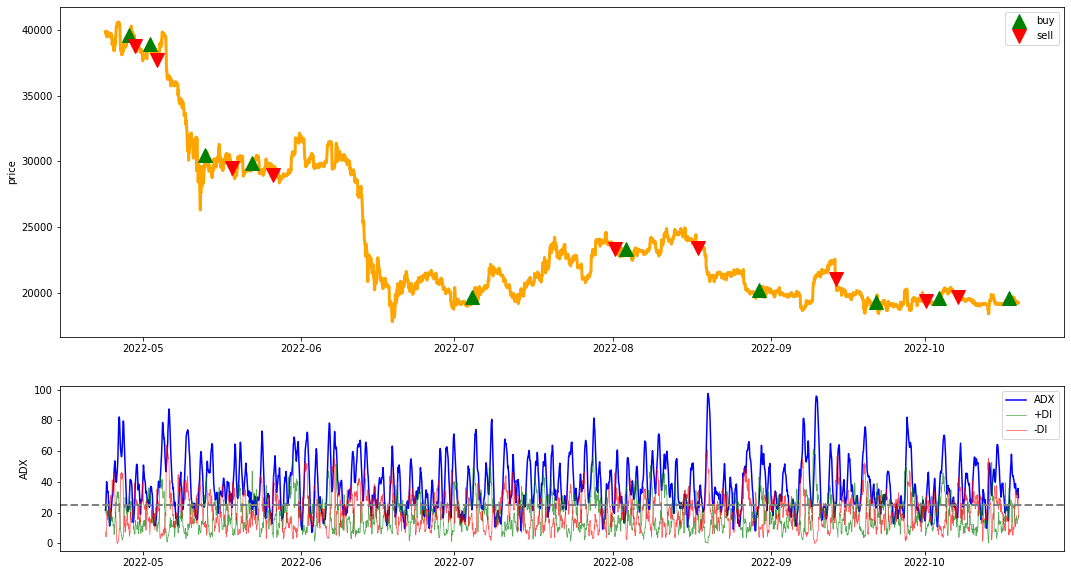

In [8]:
# visualizzazione dei risultati della strategia applicata al
# dataset scaricato all'inizio

fig, (ax_price, ax_adx) = plt.subplots(2, figsize=(18, 10), gridspec_kw={'height_ratios': [2, 1]})

ax_price.plot(candles['close'], linewidth=3, color='orange')
ax_price.plot(candles.index[1:], buy_price, marker='^', color='green', markersize=14, linewidth=0, label='buy')
ax_price.plot(candles.index[1:], sell_price, marker='v', color='red', markersize=14, linewidth=0, label='sell')
ax_price.set_ylabel('price')
ax_price.legend()

ax_adx.plot(candles['ADX' + str(interval)], color='blue', label='ADX', linewidth=1.5)
ax_adx.plot(candles['+DI' + str(interval)], color='green', label='+DI', linewidth=0.75, alpha=0.66)
ax_adx.plot(candles['-DI' + str(interval)], color='red', label='-DI', linewidth=0.75, alpha=0.66)
ax_adx.axhline(25, color='grey', linewidth=2, linestyle='--')
ax_adx.set_ylabel('ADX')
ax_adx.legend()

plt.show()